In [1]:
# Import necessary libraries
!pip install -q imagecodecs
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Machine Learning / Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Others
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 36.5 MB/s eta 0:00:00:00:0100:01
All libraries imported successfully!


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2

# 載官方 COCO 上預訓練好的模型
model_pretrained = maskrcnn_resnet50_fpn_v2(weights=None)

# 取出 backbone
backbone = model_pretrained.backbone

# 建立自己的 MaskRCNN（改成你的類別數）
model = MaskRCNN(
    backbone,
    num_classes=5,  # 你的資料集類別數 + 背景（通常背景是第0類）
)

# 可以選擇要不要先加載自己訓練的checkpoint（如果有）
checkpoint_path = '/kaggle/input/final_6/pytorch/default/1/model_new5.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))

print("✅ Mask R-CNN with ResNet50-FPN V2 pretrained on COCO loaded successfully!")

✅ Mask R-CNN with ResNet50-FPN V2 pretrained on COCO loaded successfully!


In [ ]:
"""
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN

# Load a pre-trained ResNet-50 model
#resnet = torchvision.models.resnet50(pretrained=True)  # 不用 pretrained=True 因為你要load自己的權重
resnet = torchvision.models.resnet50(weights=None)
# Build Sequential backbone
resnet_backbone = torch.nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1,
    resnet.layer2,
    resnet.layer3,
    resnet.layer4,
)

# Add FPN on top
backbone = BackboneWithFPN(
    resnet_backbone,
    return_layers={"4": "0", "5": "1", "6": "2", "7": "3"},  # 用 int 作為 key
    in_channels_list=[256, 512, 1024, 2048],
    out_channels=256,
)

# Define the Mask R-CNN model
model = MaskRCNN(
    backbone,
    num_classes=5,
)

# Load checkpoint
checkpoint_path = '/kaggle/input/epoch6/pytorch/default/1/model_new2.pth'
model.load_state_dict(torch.load(checkpoint_path))

print("✅ Mask R-CNN with ResNet-50 backbone initialized successfully!")
"""

In [ ]:
"""
# Import necessary modules
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Load a pre-trained ResNeXt-50-32x4d model
#backbone = torchvision.models.resnext50_32x4d(pretrained=True)
backbone = torchvision.models.resnext50_32x4d(weights=None)
# Add FPN (Feature Pyramid Network) on top of the backbone
backbone = BackboneWithFPN(
    backbone,
    return_layers={"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"},
    in_channels_list=[256, 512, 1024, 2048],
    out_channels=256,
)

# Define the model
model = MaskRCNN(
    backbone,
    num_classes=5,  # 4 types of cells + 1 background
)

checkpoint_path = '/kaggle/input/next1/pytorch/default/1/model_new1 (1).pth'
model.load_state_dict(torch.load(checkpoint_path))
print("Mask R-CNN with ResNeXt-50 backbone initialized successfully!")
"""

In [3]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Move model to device
model.to(device)

Using device: cuda


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [4]:
import skimage.io as sio
from pycocotools import mask as mask_utils
from PIL import Image
import numpy as np

def read_maskfile(filepath):
    mask_array = sio.imread(filepath)
    return mask_array
    
def decode_maskobj(mask_obj):
    return mask_utils.decode(mask_obj)

def encode_mask(binary_mask):
    arr = np.asfortranarray(binary_mask).astype(np.uint8)
    rle = mask_utils.encode(arr)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle

In [5]:
from skimage import measure
from torchvision.ops import masks_to_boxes
import io
import cv2
from skimage import io
class CellSegmentationDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
        if self.mode == 'train':
            self.image_folders = sorted(os.listdir(self.root_dir))
        else:
            self.image_files = sorted(os.listdir(self.root_dir))

    def __len__(self):
        if self.mode == 'train':
            return len(self.image_folders)
        else:
            return len(self.image_files)
        
    def __getitem__(self, idx):
        if self.mode == 'train':
            folder_name = self.image_folders[idx]
            folder_path = os.path.join(self.root_dir, folder_name)

            # 讀取原始圖片
            image_path = os.path.join(folder_path, "image.tif")
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)
            # --- 轉 tensor ---
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # (C, H, W)

            # 下面這裡新增：
            masks = []    # (N, H, W)
            boxes = []    # (N, 4)
            labels = []   # (N, )

            for class_idx in range(4):
                class_path = os.path.join(folder_path, f"class{class_idx+1}.tif")
                if os.path.exists(class_path):
                    mask = np.array(sio.imread(class_path))
                    num_labels, labeled_mask = cv2.connectedComponents(mask.astype(np.uint8))
                    for label_id in range(1, num_labels):  # Skip background (0)
                        binary_mask = (labeled_mask == label_id).astype(np.uint8)
                        masks.append(binary_mask)
                        labels.append(class_idx+1)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            boxes = masks_to_boxes(masks)
            keep = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[keep]
            masks = masks[keep]
            labels = labels[keep]
            target = {
                "boxes": boxes,
                "labels": labels,
                "masks": masks,
                "image_id": torch.tensor([idx]),
                "area": masks.flatten(1).sum(1),
                "iscrowd": torch.zeros((len(masks),), dtype=torch.int64)
            }
            return image, target     
        else:  # test 模式
            image_name = self.image_files[idx]
            image_path = os.path.join(self.root_dir, image_name)
            image = read_maskfile(image_path)

            if self.transform:
                image = self.transform(image)

            image = torch.from_numpy(image).permute(2, 0, 1).float()
            return image, image_name

In [6]:
from torch.utils.data import DataLoader

# collate_fn: 把 batch 資料組成 list
def collate_fn(batch):
    return tuple(zip(*batch))

# 建立 train dataset
train_dataset = CellSegmentationDataset(root_dir='/kaggle/input/train-dataset-1/train', mode='train')

# 建立 test dataset
test_dataset = CellSegmentationDataset(root_dir='/kaggle/input/train-dataset-1/test_release', mode='test')

# 用 DataLoader 包起來
train_loader = DataLoader(
    train_dataset,
    batch_size=2,          # 你可以自由調，通常小型資料集 batch=2或4都可以
    shuffle=True,
    #num_workers=8,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,          # test可以batch=1，因為你是拿來做推論
    shuffle=False,
    #num_workers=8,
    collate_fn=collate_fn
)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

num_epochs = 10
learning_rate = 0.0005

# 優化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 把模型搬到 device
model = model.to(device)

# 訓練迴圈
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # 每個 epoch 存一次模型
    torch.save(model.state_dict(), f"model_new{epoch+1}.pth")
    print(f"✅ Model saved at epoch {epoch+1}.")

print("🎉 Training finished!")

In [14]:
import torch
import json
import os
import numpy as np
import matplotlib.pyplot as plt  # ⬅️ 新增
from tqdm import tqdm
from pycocotools import mask as coco_mask
from PIL import Image

def encode_mask_to_rle(mask):
    rle = coco_mask.encode(np.asfortranarray(mask.astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('utf-8')  # coco格式要求是string
    return rle

def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    image = torch.from_numpy(image).permute(2, 0, 1).float()  # (C, H, W)
    return image

def inference_and_save(model, image_info_json_path, test_dir, device, output_json_path, score_threshold=0.05):
    # 讀取 image_info_list
    with open(image_info_json_path, 'r') as f:
        image_info_list = json.load(f)
    
    model.eval()
    results = []
    all_scores = []  # ⬅️ 新增：收集所有 score

    for info in tqdm(image_info_list, desc="Inferencing"):
        image_id = info['id']
        file_name = info['file_name']
        height = info['height']
        width = info['width']

        image_path = os.path.join(test_dir, file_name)
        image = load_test_image(image_path).to(device).unsqueeze(0)  # (1, C, H, W)

        with torch.no_grad():
            outputs = model(image)

        output = outputs[0]

        boxes = output['boxes'].cpu().numpy()
        scores = output['scores'].cpu().numpy()
        labels = output['labels'].cpu().numpy()
        masks = output['masks'].cpu().numpy()

        for box, score, label, mask in zip(boxes, scores, labels, masks):
            if score < score_threshold:
                continue  # 忽略信心低的預測

            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1

            if (x1 <= 0) or (y1 <= 0) or (x2 >= width) or (y2 >= height):
                continue  # 忽略碰到邊界的預測

            mask = mask[0] > 0.5  # 二值化
            rle = encode_mask_to_rle(mask)

            results.append({
                'image_id': image_id,
                'bbox': [float(x1), float(y1), float(w), float(h)],
                'score': float(score),
                'category_id': int(label),
                'segmentation': rle
            })

            all_scores.append(score)  # ⬅️ 新增：記錄這個預測的score

    # 儲存成 JSON
    with open(output_json_path, 'w') as f:
        json.dump(results, f)

    print(f"✅ Saved {len(results)} predictions to {output_json_path}")

    # ⬇️ 新增：畫出score分布
    if len(all_scores) > 0:
        plt.figure(figsize=(8, 6))
        plt.hist(all_scores, bins=50, range=(0, 1), color='skyblue', edgecolor='black')
        plt.title('Distribution of Prediction Scores')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ No predictions to plot.")

Inferencing: 100%|██████████| 101/101 [00:43<00:00,  2.33it/s]


✅ Saved 6689 predictions to result.json


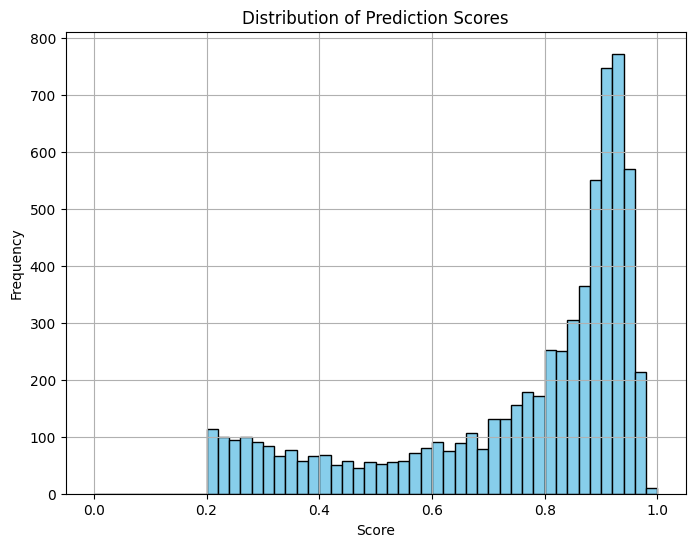

In [17]:
inference_and_save(
    model=model,
    image_info_json_path="/kaggle/input/train-dataset-1/test_image_name_to_ids.json",  # <<< 這邊是JSON檔，不是list
    test_dir="/kaggle/input/train-dataset-1/test_release", 
    device=device, 
    output_json_path="result.json",
    score_threshold=0.2
)